In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam




In [2]:
time_window = 15
prediction_horizon = 10

In [10]:
df = pd.read_csv(r"CNNdata\fulldata.csv")
df["DateTime"] = pd.to_datetime(df["DateTime"])
df.set_index(df["DateTime"], inplace=True)
df = df.resample("50ms").mean()
df = df.fillna(method='ffill')  # Forward fill
df
del df["DateTime"]


C:\Users\dbjac\AppData\Local\Temp\ipykernel_20984\511533882.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill


In [3]:
df_FB = pd.read_csv(r"CNNdata\fulldata.csv")

df_FB
del df_FB["DateTime"]

C:\Users\dbjac\AppData\Local\Temp\ipykernel_20984\2678273852.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_FB = df_FB.fillna(method='ffill')  # Forward fill


Text(0.5, 1.0, 'Distribution of Log-Returns at 50ms ')

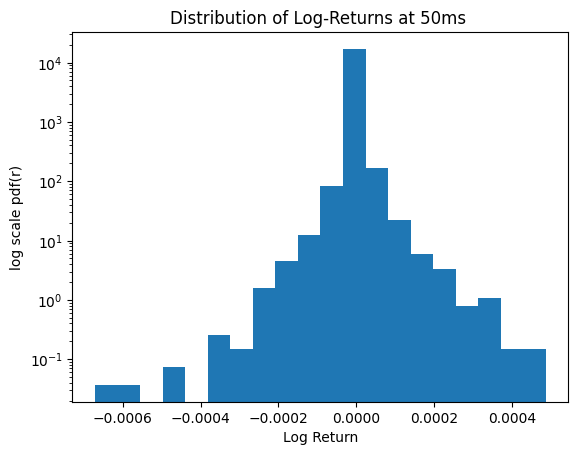

In [4]:
plt.hist(df["Returns"],density=True,bins=20)
plt.yscale("log")
plt.ylabel("log scale pdf(r)")
plt.xlabel("Log Return")
plt.title("Distribution of Log-Returns at 50ms ")



In [5]:
print(df.dtypes)
print(df.isnull().sum().cumsum())


Price                 float64
Mid                   float64
WAP                   float64
Returns               float64
Spread                float64
                       ...   
Is_3                  float64
Is_4                  float64
Is_5                  float64
Next_Mid_Direction    float64
Mid_Change            float64
Length: 71, dtype: object
Price                 0
Mid                   0
WAP                   0
Returns               0
Spread                0
                     ..
Is_3                  0
Is_4                  0
Is_5                  0
Next_Mid_Direction    0
Mid_Change            0
Length: 71, dtype: int64


In [6]:
for index in df:
    print(index,df[index].isna().sum())

Price 0
Mid 0
WAP 0
Returns 0
Spread 0
Delta_AP_1 0
Delta_BP_1 0
Size 0
Direction 0
MA5_Order_Direction 0
MA10_Order_Direction 0
MA15_Order_Direction 0
Ask_Price_Level_1 0
Ask_Volume_Level_1 0
Bid_Price_Level_1 0
Bid_Volume_Level_1 0
Ask_Price_Level_2 0
Ask_Volume_Level_2 0
Bid_Price_Level_2 0
Bid_Volume_Level_2 0
Ask_Price_Level_3 0
Ask_Volume_Level_3 0
Bid_Price_Level_3 0
Bid_Volume_Level_3 0
Ask_Price_Level_4 0
Ask_Volume_Level_4 0
Bid_Price_Level_4 0
Bid_Volume_Level_4 0
Ask_Price_Level_5 0
Ask_Volume_Level_5 0
Bid_Price_Level_5 0
Bid_Volume_Level_5 0
Ask_Price_Level_6 0
Ask_Volume_Level_6 0
Bid_Price_Level_6 0
Bid_Volume_Level_6 0
Ask_Price_Level_7 0
Ask_Volume_Level_7 0
Bid_Price_Level_7 0
Bid_Volume_Level_7 0
Ask_Price_Level_8 0
Ask_Volume_Level_8 0
Bid_Price_Level_8 0
Bid_Volume_Level_8 0
Ask_Price_Level_9 0
Ask_Volume_Level_9 0
Bid_Price_Level_9 0
Bid_Volume_Level_9 0
Ask_Price_Level_10 0
Ask_Volume_Level_10 0
Bid_Price_Level_10 0
Bid_Volume_Level_10 0
Ask_Volume 0
Bid_Volume 

In [7]:
def create_target(df, prediction_horizon=10):
    """Creates target variable for predicting price movement after prediction_horizon steps."""
    target = np.zeros(len(df) - prediction_horizon)  # Initialize target array

    for i in range(len(df) - prediction_horizon):
      current_price = df['Mid'].iloc[i]
      future_price = df['Mid'].iloc[i + prediction_horizon]

      if future_price > current_price:
          target[i] = 2  # Up
      elif future_price < current_price:
          target[i] = 0  # Down
      else:
          target[i] = 1  # Neutral

    return target



In [5]:
def create_image_data(X,time_window):
    num_samples = len(X) - time_window + 1
    num_channels = X.shape[1]
    images = np.zeros((num_samples,num_channels,time_window))
    for i in range(num_samples):
        images[i] = X[i:i+time_window].T
    return images

In [11]:


X = df.drop(["Next_Mid_Direction", "Mid_Change"], axis=1)  # Features
X = X[:-prediction_horizon]

y = create_target(df, prediction_horizon)  # Target

# Split the data AFTER creating the target variable
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Convert Size to float
X_train["Size"] = X_train["Size"].astype(np.float64)
X_val["Size"] = X_val["Size"].astype(np.float64)
X_test["Size"] = X_test["Size"].astype(np.float64)

numerical_cols = X_train.select_dtypes(include=np.float64).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train_images = create_image_data(X_train, time_window)
y_train_images = y_train[:len(X_train_images)] 

X_val_images = create_image_data(X_val, time_window)
y_val_images = y_val[:len(X_val_images)] 

X_test_images = create_image_data(X_test, time_window)
y_test_images = y_test[:len(X_test_images)] 

X_train.head()

'X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])\nX_test[numerical_cols] = scaler.transform(X_test[numerical_cols])\n\nX_train_images = create_image_data(X_train, time_window)\ny_train_images = y_train[:len(X_train_images)] \n\nX_val_images = create_image_data(X_val, time_window)\ny_val_images = y_val[:len(X_val_images)] \n\nX_test_images = create_image_data(X_test, time_window)\ny_test_images = y_test[:len(X_test_images)] \n\nX_train.head()'

In [4]:


def create_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),  # Input layer (important to define input shape)

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  # Convolutional layer
        layers.BatchNormalization(), #Batch Normalization Layer
        layers.MaxPooling1D(pool_size=2),  # Max pooling

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  # Convolutional layer
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2), 

        layers.Flatten(), 
        layers.Dense(128, activation='relu'),  
        layers.Dropout(0.5),  
        layers.Dense(3,activation="softmax") 
    ])
    return model




In [11]:


input_shape = (X_train_images.shape[1], X_train_images.shape[2])
model = create_model(input_shape)
learning_rate = 0.0001  
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

#tf.keras.utils.plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)





In [12]:
batch_size = 32
epochs = 15

# Train the model
history = model.fit(X_train_images, y_train_images, epochs=epochs, 
                batch_size=batch_size, validation_data=(X_val_images, y_val_images), verbose=1)



Epoch 1/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - accuracy: 0.7480 - loss: 0.6627 - val_accuracy: 0.8770 - val_loss: 0.3074
Epoch 2/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - accuracy: 0.8636 - loss: 0.3455 - val_accuracy: 0.8996 - val_loss: 0.2574
Epoch 3/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.8866 - loss: 0.2947 - val_accuracy: 0.9096 - val_loss: 0.2322
Epoch 4/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.9010 - loss: 0.2603 - val_accuracy: 0.9185 - val_loss: 0.2123
Epoch 5/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9095 - loss: 0.2417 - val_accuracy: 0.9225 - val_loss: 0.2049
Epoch 6/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.9172 - loss: 0.2226 - val_accuracy: 0.9236 - val_loss: 0.2165
Epoch 7/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.9214 - loss: 0.2117 - val_accuracy: 0.9308 - val_loss: 0.1938
Epoch 8/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 

In [15]:


# Train the model
history = model.fit(X_train_images, y_train_images, epochs=epochs, 
                batch_size=batch_size, validation_data=(X_val_images, y_val_images), verbose=1)



Epoch 1/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.9474 - loss: 0.1469 - val_accuracy: 0.9409 - val_loss: 0.1616
Epoch 2/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.9485 - loss: 0.1439 - val_accuracy: 0.9466 - val_loss: 0.1482
Epoch 3/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.9496 - loss: 0.1410 - val_accuracy: 0.9459 - val_loss: 0.1562
Epoch 4/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.9508 - loss: 0.1360 - val_accuracy: 0.9485 - val_loss: 0.1494
Epoch 5/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.9518 - loss: 0.1341 - val_accuracy: 0.9458 - val_loss: 0.1518
Epoch 6/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.9532 - loss: 0.1316 - val_accuracy: 0.9452 - val_loss: 0.1729
Epoch 7/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.9540 - loss: 0.1286 - val_accuracy: 0.9496 - val_loss: 0.1610
Epoch 8/15
10237/10237 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 

In [16]:
print(len(y_train[y_train==2])/len(y_train),len(y_train[y_train==2])," Up")
print(len(y_train[y_train==0])/len(y_train),len(y_train[y_train==0]),"Down")
print(len(y_train[y_train==1])/len(y_train),len(y_train[y_train==1]),"Neutral")
print(len(y_train),"Training Size\n")

print(len(y_test_images[y_test_images==2])/len(y_test_images),len(y_test_images[y_test_images==2])," Up")
print(len(y_test_images[y_test_images==0])/len(y_test_images),len(y_test_images[y_test_images==0])," Down")
print(len(y_test_images[y_test_images==1])/len(y_test_images),len(y_test_images[y_test_images==1])," Neutral")
print(len(y_test_images),"Testing Size")

print("\n",len(y_test_images)/len(y_train_images))

0.1576124451282427 51631  Up
0.16604392182720662 54393 Down
0.6763436330445507 221558 Neutral
327582 Training Size

0.1589558725047376 11156  Up
0.16076542752518416 11283  Down
0.6802786999700782 47744  Neutral
70183 Testing Size

 0.21425475015874568


2194/2194 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Test Accuracy (using predictions): 0.9378766937862445
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     11283
           1       0.98      0.96      0.97     47744
           2       0.83      0.91      0.87     11156

    accuracy                           0.94     70183
   macro avg       0.90      0.91      0.90     70183
weighted avg       0.94      0.94      0.94     70183

[[ 9640   494  1149]
 [  735 46029   980]
 [  555   447 10154]]
Test Accuracy (using model.evaluate): 0.9378767013549805


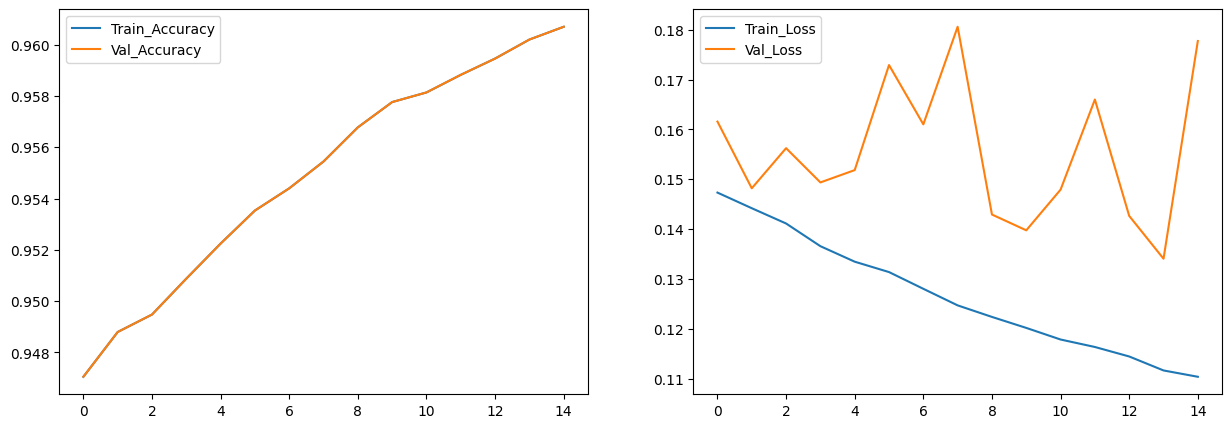

In [17]:
#Make predictions
predictions = model.predict(X_test_images)
predicted_labels = np.argmax(predictions, axis=1) #Axis 1 is for each sample
accuracy = accuracy_score(y_test_images.astype(int), predicted_labels)
print(f"Test Accuracy (using predictions): {accuracy}")

#Print classification report
print(classification_report(y_test_images.astype(int),predicted_labels))

#Print confusion matrix
print(confusion_matrix(y_test_images.astype(int),predicted_labels))

# Compare with model.evaluate (should be the same)
loss, accuracy_eval = model.evaluate(X_test_images, y_test_images, verbose=0)
print(f"Test Accuracy (using model.evaluate): {accuracy_eval}")

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(history.history["accuracy"],label="Train_Accuracy")
ax[0].plot(history.history["accuracy"],label="Val_Accuracy")
ax[1].plot(history.history["loss"],label="Train_Loss")
ax[1].plot(history.history["val_loss"],label="Val_Loss")
ax[0].legend()
ax[1].legend()


In [20]:
model.save("C150.keras")

In [17]:

time_window = 15
prediction_horizon = 10

X_FB = df_FB.drop(["Next_Mid_Direction", "Mid_Change"], axis=1)  # Features

y_FB = create_target(df_FB, prediction_horizon)  # Target

# Convert Size to float
X_FB["Size"] = X_FB["Size"].astype(np.float64)

numerical_cols = X_FB.select_dtypes(include=np.float64).columns
X_FB[numerical_cols] = scaler.transform(X_FB[numerical_cols])

X_FB_images = create_image_data(X_FB,time_window)

y_FB = y_FB[:len(X_FB_images)]


In [30]:

print(len(y_FB))
print(len(X_FB_images))

467971
467971


In [31]:
model = tf.keras.models.load_model('C150.h5')  # Replace 'my_model.h5' with your actual filename

loss_fb, accuracy_fb = model.evaluate(X_FB_images, y_FB, verbose=1)
print(f'FB Loss: {loss_fb:.4f}')
print(f'FB Accuracy: {accuracy_fb * 100:.2f}%')

# Get predictions
predictions_fb = model.predict(X_FB_images)

# Convert predictions to class labels
predicted_labels_fb = np.argmax(predictions_fb, axis=1)

# Calculate accuracy using sklearn.metrics.accuracy_score
accuracy_fb_pred = accuracy_score(y_FB, predicted_labels_fb)
print(f"FB Test Accuracy (using predictions): {accuracy_fb_pred}")

# Print classification report (more detailed metrics)
print(classification_report(y_FB, predicted_labels_fb))

# Print confusion matrix
print(confusion_matrix(y_FB, predicted_labels_fb))


14625/14625 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9670 - loss: 0.1140
FB Loss: 0.1290
FB Accuracy: 96.18%
14625/14625 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step
FB Test Accuracy (using predictions): 0.9618160099664296
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92     75567
         1.0       0.99      0.98      0.98    319136
         2.0       0.87      0.95      0.91     73268

    accuracy                           0.96    467971
   macro avg       0.94      0.94      0.94    467971
weighted avg       0.96      0.96      0.96    467971

[[ 67699   2227   5641]
 [  2165 312636   4335]
 [  1685   1816  69767]]
